In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2D, Reshape, Conv2DTranspose
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout, Activation
from keras.optimizers import Adadelta, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import load_img,img_to_array
import cv2

from tensorflow.python.keras import losses

Using TensorFlow backend.


In [2]:
train_img=[]
train_mask=[]
valid_img=[]
valid_mask=[]

train = open("../VOC_2011_TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/train_2.txt", 'r')
lines = train.readlines()
for i, line in enumerate(lines):
    train_img.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/JPEGImages/"+line.split('\n')[0]+".jpg")
    train_mask.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/SegmentationClass/"+line.split('\n')[0]+".png")
train.close()

valid = open("../VOC_2011_TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/val_2.txt", 'r')
lines = valid.readlines()
for i, line in enumerate(lines):
    valid_img.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/JPEGImages/"+line.split('\n')[0]+".jpg")
    valid_mask.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/SegmentationClass/"+line.split('\n')[0]+".png")
valid.close()

In [27]:


def category_label(labels, dims, n_labels):
    x=np.zeros([dims[0], dims[1], n_labels])
    for i in range(dims[0]):
        for j in range(dims[1]):
            x[i, j, labels[i][j]==1]    
    
    return x


def data_gen_small(img_list, mask_list, batch_size, dims, n_labels):
    while True:
        #ix = np.random.choice(np.arange(len(lists)), batch_size)
        imgs = []
        labels =[]
        
        for img_path in img_list:
            original_img = cv2.imread(img_path)[:,:,::-1]
            resized_img = cv2.resize(original_img, dims)
            array_img = img_to_array(resized_img)/255.0
            imgs.append(array_img)
            
        for mask_path in mask_list:
            original_mask = cv2.imread(mask_path)
            resized_mask = cv2.resize(original_mask, dims)
            array_mask = category_label(resized_mask[:,:,0], dims, n_labels)
            labels.append(array_mask)
            
        imgs = np.array(imgs)
        labels = np.array(labels)
        
        yield imgs, labels
            

In [28]:
# Saved in the d2l package for later use
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

# Saved in the d2l package for later use
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

def rgb_to_onehot(rgb_image, colormap = VOC_COLORMAP):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = VOC_COLORMAP):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in range(len(colormap)):
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [22]:
# Get and resize train images and masks
def get_data(img_path_list, mask_path_list, train=True):
    n_classes =21
    X = np.zeros((len(img_path_list), 128, 128, 3), dtype=np.float32)
    y = np.zeros((len(img_path_list), 128, 128, n_classes), dtype=np.float32)
    
    print('Getting and resizing images ... ')
    for n, img in tqdm_notebook(enumerate(img_path_list), total=len(img_path_list)):
        # Load images
        img = load_img(img)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128), mode='constant', preserve_range=True)

        mask = cv2.imread(mask_path_list[n],0)
        mask = cv2.resize(mask, (128,128), interpolation=cv2.INTER_NEAREST)
        
        one_hot = np.zeros((mask.shape[0], mask.shape[1], n_classes))
        for i , unique_value in enumerate(np.unique(mask)):
            one_hot[:, :, i][mask==unique_value]=1

        X[n] = x_img / 255.0
        if train:
            y[n] = one_hot
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train_img, train_mask, train=True)



Getting and resizing images ... 



Done!


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)

In [8]:
def segnet():
    inputs = Input((128,128,3))
    
    encoder = Conv2D(32, (3, 3), padding='same')(inputs)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(32, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder0 = Activation('relu')(encoder)
    endcoder0_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder0)
    
    encoder = Conv2D(64, (3, 3), padding='same')(endcoder0_pool)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(64, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder1 = Activation('relu')(encoder)
    endcoder1_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder1)
    
    encoder = Conv2D(128, (3, 3), padding='same')(endcoder1_pool)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(128, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder2 = Activation('relu')(encoder)
    endcoder2_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder2)
    
    encoder = Conv2D(256, (3, 3), padding='same')(endcoder2_pool)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(256, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder3 = Activation('relu')(encoder)
    endcoder3_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder3)
    
    encoder = Conv2D(512, (3, 3), padding='same')(endcoder3_pool)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(512, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder4 = Activation('relu')(encoder)
    endcoder4_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder4)
    
    center = Conv2D(1024, (3, 3), padding='same')(endcoder4_pool)
    encoder = BatchNormalization()(center)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(1024, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    
    decoder = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(encoder)
    decoder = concatenate([encoder4, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(512, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(512, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    
    decoder = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(decoder)
    decoder = concatenate([encoder3, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(256, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(256, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    
    decoder = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(decoder)
    decoder = concatenate([encoder2, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(128, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(128, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    
    decoder = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(decoder)
    decoder = concatenate([encoder1, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(64, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(64, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    
    decoder = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(decoder)
    decoder = concatenate([encoder0, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(32, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(32, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    
    outputs = Conv2D(21, (1,1), activation='sigmoid')(decoder)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [9]:
inputs = Input(shape=(128,128,3))

In [10]:
model = segnet()

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 64)   36928       activation_23[0][0]              
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 64, 64, 64)   256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 64, 64, 64)   0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
conv2d_transpose_5 (Conv2DTrans (None, 128, 128, 32) 8224        activation_24[0][0]              
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 128, 128, 64) 0           activation_2[0][0]               
          

In [14]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [15]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss, 'accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 64)   36928       activation_23[0][0]              
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 64, 64, 64)   256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 64, 64, 64)   0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
conv2d_transpose_5 (Conv2DTrans (None, 128, 128, 32) 8224        activation_24[0][0]              
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 128, 128, 64) 0           activation_2[0][0]               
          

In [24]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Train on 105 samples, validate on 19 samples
Epoch 1/100
105/105 [==============================] - ETA: 55s - loss: 1.6623 - dice_loss: 0.9183 - accuracy: 0.009 - ETA: 24s - loss: 1.6503 - dice_loss: 0.9162 - accuracy: 0.010 - ETA: 4s - loss: 1.6387 - dice_loss: 0.9142 - accuracy: 0.011 - 60s 571ms/step - loss: 1.6352 - dice_loss: 0.9126 - accuracy: 0.0140 - val_loss: 1.5940 - val_dice_loss: 0.9126 - val_accuracy: 0.0000e+00
Epoch 2/100
105/105 [==============================] - ETA: 29s - loss: 1.5712 - dice_loss: 0.9029 - accuracy: 0.096 - ETA: 16s - loss: 1.5646 - dice_loss: 0.9021 - accuracy: 0.109 - ETA: 3s - loss: 1.5584 - dice_loss: 0.9017 - accuracy: 0.119 - 47s 447ms/step - loss: 1.5564 - dice_loss: 0.9011 - accuracy: 0.1250 - val_loss: 17.9878 - val_dice_loss: 0.9658 - val_accuracy: 0.0643
Epoch 3/100
105/105 [==============================] - ETA: 28s - loss: 1.5136 - dice_loss: 0.8976 - accuracy: 0.212 - ETA: 15s - loss: 1.5078 - dice_loss: 0.8968 - accuracy: 0.241 - ETA: 

105/105 [==============================] - ETA: 27s - loss: 1.0358 - dice_loss: 0.7772 - accuracy: 0.668 - ETA: 16s - loss: 1.0295 - dice_loss: 0.7732 - accuracy: 0.705 - ETA: 3s - loss: 1.0239 - dice_loss: 0.7703 - accuracy: 0.713 - 46s 433ms/step - loss: 1.0242 - dice_loss: 0.7713 - accuracy: 0.7082 - val_loss: 1.1422 - val_dice_loss: 0.8232 - val_accuracy: 0.6319
Epoch 23/100
105/105 [==============================] - ETA: 27s - loss: 1.0018 - dice_loss: 0.7597 - accuracy: 0.708 - ETA: 15s - loss: 1.0078 - dice_loss: 0.7635 - accuracy: 0.703 - ETA: 3s - loss: 1.0039 - dice_loss: 0.7615 - accuracy: 0.701 - 45s 429ms/step - loss: 0.9995 - dice_loss: 0.7541 - accuracy: 0.7106 - val_loss: 1.1537 - val_dice_loss: 0.8291 - val_accuracy: 0.5562
Epoch 24/100
105/105 [==============================] - ETA: 31s - loss: 0.9537 - dice_loss: 0.7334 - accuracy: 0.792 - ETA: 17s - loss: 0.9643 - dice_loss: 0.7400 - accuracy: 0.745 - ETA: 3s - loss: 0.9730 - dice_loss: 0.7455 - accuracy: 0.713 - 48

105/105 [==============================] - ETA: 26s - loss: 0.5823 - dice_loss: 0.4807 - accuracy: 0.716 - ETA: 14s - loss: 0.5834 - dice_loss: 0.4811 - accuracy: 0.727 - ETA: 3s - loss: 0.5916 - dice_loss: 0.4864 - accuracy: 0.716 - 41s 393ms/step - loss: 0.5915 - dice_loss: 0.4860 - accuracy: 0.7187 - val_loss: 0.7403 - val_dice_loss: 0.5614 - val_accuracy: 0.5621
Epoch 44/100
105/105 [==============================] - ETA: 28s - loss: 0.5717 - dice_loss: 0.4720 - accuracy: 0.723 - ETA: 16s - loss: 0.5797 - dice_loss: 0.4770 - accuracy: 0.711 - ETA: 3s - loss: 0.5672 - dice_loss: 0.4681 - accuracy: 0.724 - 47s 450ms/step - loss: 0.5761 - dice_loss: 0.4856 - accuracy: 0.7163 - val_loss: 0.7245 - val_dice_loss: 0.5701 - val_accuracy: 0.5760
Epoch 45/100
105/105 [==============================] - ETA: 29s - loss: 0.5345 - dice_loss: 0.4442 - accuracy: 0.764 - ETA: 16s - loss: 0.5573 - dice_loss: 0.4598 - accuracy: 0.735 - ETA: 3s - loss: 0.5661 - dice_loss: 0.4654 - accuracy: 0.721 - 48

105/105 [==============================] - ETA: 37s - loss: 0.3709 - dice_loss: 0.3007 - accuracy: 0.791 - ETA: 20s - loss: 0.3694 - dice_loss: 0.2989 - accuracy: 0.794 - ETA: 4s - loss: 0.4001 - dice_loss: 0.3207 - accuracy: 0.766 - 56s 535ms/step - loss: 0.3943 - dice_loss: 0.3080 - accuracy: 0.7713 - val_loss: 0.7554 - val_dice_loss: 0.5613 - val_accuracy: 0.4865
Epoch 65/100
105/105 [==============================] - ETA: 30s - loss: 0.3754 - dice_loss: 0.3015 - accuracy: 0.785 - ETA: 17s - loss: 0.3676 - dice_loss: 0.2957 - accuracy: 0.790 - ETA: 3s - loss: 0.3875 - dice_loss: 0.3099 - accuracy: 0.772 - 50s 479ms/step - loss: 0.3838 - dice_loss: 0.3022 - accuracy: 0.7759 - val_loss: 0.6734 - val_dice_loss: 0.4969 - val_accuracy: 0.5678
Epoch 66/100
105/105 [==============================] - ETA: 40s - loss: 0.3436 - dice_loss: 0.2796 - accuracy: 0.804 - ETA: 23s - loss: 0.3629 - dice_loss: 0.2926 - accuracy: 0.790 - ETA: 4s - loss: 0.3775 - dice_loss: 0.3022 - accuracy: 0.778 - 61

105/105 [==============================] - ETA: 29s - loss: 0.3147 - dice_loss: 0.2484 - accuracy: 0.794 - ETA: 18s - loss: 0.3329 - dice_loss: 0.2603 - accuracy: 0.783 - ETA: 3s - loss: 0.3410 - dice_loss: 0.2659 - accuracy: 0.778 - 49s 466ms/step - loss: 0.3350 - dice_loss: 0.2545 - accuracy: 0.7828 - val_loss: 0.4974 - val_dice_loss: 0.3766 - val_accuracy: 0.6656
Epoch 86/100
105/105 [==============================] - ETA: 29s - loss: 0.3346 - dice_loss: 0.2619 - accuracy: 0.781 - ETA: 16s - loss: 0.3320 - dice_loss: 0.2598 - accuracy: 0.784 - ETA: 3s - loss: 0.3238 - dice_loss: 0.2534 - accuracy: 0.790 - 47s 446ms/step - loss: 0.3201 - dice_loss: 0.2455 - accuracy: 0.7935 - val_loss: 0.5425 - val_dice_loss: 0.4065 - val_accuracy: 0.6322
Epoch 87/100
105/105 [==============================] - ETA: 35s - loss: 0.2845 - dice_loss: 0.2240 - accuracy: 0.820 - ETA: 18s - loss: 0.3099 - dice_loss: 0.2423 - accuracy: 0.799 - ETA: 4s - loss: 0.3103 - dice_loss: 0.2422 - accuracy: 0.799 - 53

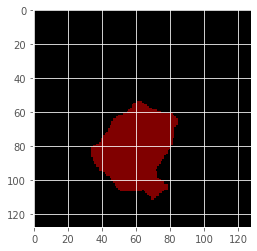

In [43]:
plt.imshow(onehot_to_rgb(model.predict(X_train[100].reshape(1,128,128,3)).reshape(128,128,21)))

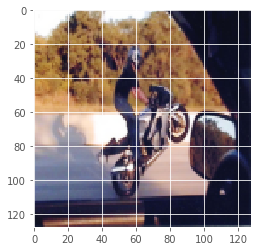

In [44]:
plt.imshow(X_train[100])

### 10 epochs

In [45]:
def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)

    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([concat_tensor, decoder], axis=-1)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation('relu')(decoder)
    return decoder

inputs = Input((128,128,3))

encoder0_pool, encoder0 = encoder_block(inputs, 32)
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)

center = conv_block(encoder4_pool, 1024)

decoder4 = decoder_block(center, encoder4, 512)
decoder3 = decoder_block(decoder4, encoder3, 256)
decoder2 = decoder_block(decoder3, encoder2, 128)
decoder1 = decoder_block(decoder2, encoder1, 64)
decoder0 = decoder_block(decoder1, encoder0, 32)

outputs = Conv2D(21, (1, 1), activation='sigmoid')(decoder0)

In [46]:
segmodel = Model(inputs=[inputs], outputs=[outputs])

In [47]:
segmodel.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss, 'accuracy'])

segmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 128, 128, 32) 128         conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 128, 128, 32) 0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 4, 4, 1024)   4096        conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 4, 4, 1024)   0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
conv2d_transpose_6 (Conv2DTrans (None, 8, 8, 512)    2097664     activation_39[0][0]              
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 8, 8, 1024)   0           activation_37[0][0]              
                                                                 conv2d_transpose_6[0][0]         
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 64, 64, 64)   36928       activation_50[0][0]              
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 64, 64, 64)   256         conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 64, 64, 64)   0           batch_normalization_51[0][0]     
__________________________________________________________________________________________________
conv2d_transpose_10 (Conv2DTran (None, 128, 128, 32) 8224        activation_51[0][0]              
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 128, 128, 64) 0           activation_29[0][0]              
          

In [48]:
segmodel.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Train on 105 samples, validate on 19 samples
Epoch 1/10
105/105 [==============================] - ETA: 1:05 - loss: 1.6662 - dice_loss: 0.9119 - accuracy: 0.03 - ETA: 28s - loss: 1.6535 - dice_loss: 0.9104 - accuracy: 0.0385 - ETA: 5s - loss: 1.6387 - dice_loss: 0.9088 - accuracy: 0.040 - 68s 643ms/step - loss: 1.6348 - dice_loss: 0.9077 - accuracy: 0.0421 - val_loss: 1.6017 - val_dice_loss: 0.9123 - val_accuracy: 0.2123
Epoch 2/10
105/105 [==============================] - ETA: 33s - loss: 1.5745 - dice_loss: 0.9020 - accuracy: 0.064 - ETA: 17s - loss: 1.5668 - dice_loss: 0.9025 - accuracy: 0.057 - ETA: 3s - loss: 1.5579 - dice_loss: 0.9011 - accuracy: 0.065 - 48s 459ms/step - loss: 1.5550 - dice_loss: 0.8996 - accuracy: 0.0712 - val_loss: 1.5945 - val_dice_loss: 0.9112 - val_accuracy: 0.5441
Epoch 3/10
105/105 [==============================] - ETA: 27s - loss: 1.5155 - dice_loss: 0.8959 - accuracy: 0.102 - ETA: 15s - loss: 1.5083 - dice_loss: 0.8945 - accuracy: 0.112 - ETA: 3s - lo

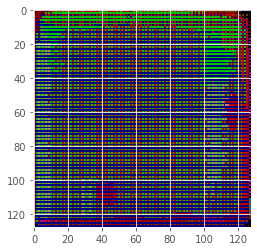

In [57]:
plt.imshow(onehot_to_rgb(segmodel.predict(X_train[3].reshape(1,128,128,3)).reshape(128,128,21)))

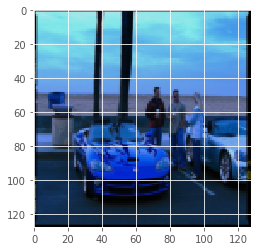

In [58]:
plt.imshow(X_train[3])